### How to push to github
##### Write the following in the git terminal:
##### git add *
##### git commit -m "Write the changes in the file that were done here"
##### git push

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import kn
from scipy.integrate import quad
import csv

In [36]:
"""
with open('Gstar.csv', 'r') as f:
    Gstarreader = csv.reader(f)
    Gstardata = {float(row[0]): float(row[1]) for row in Gstarreader}

with open('GstarS.csv', 'r') as f:
    GstarSreader = csv.reader(f)
    GstarSdata = {float(row[0]): float(row[1]) for row in GstarSreader}
"""

"\nwith open('Gstar.csv', 'r') as f:\n    Gstarreader = csv.reader(f)\n    Gstardata = {float(row[0]): float(row[1]) for row in Gstarreader}\n\nwith open('GstarS.csv', 'r') as f:\n    GstarSreader = csv.reader(f)\n    GstarSdata = {float(row[0]): float(row[1]) for row in GstarSreader}\n"

<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
C:\Users\press\AppData\Local\Temp\ipykernel_17220\1790386059.py:31: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Log plot of Y(x) for different $\sigma$ values')
C:\Users\press\AppData\Local\Temp\ipykernel_17220\3112628040.py:15: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral_result, error = quad(integrand, 4 * m**2, np.inf)


TestMeson
Frozen-out Y(x) for TestMeson = 0.005008079665809359
TestBaryon
Frozen-out Y(x) for TestBaryon = 4.747487678907731e-10


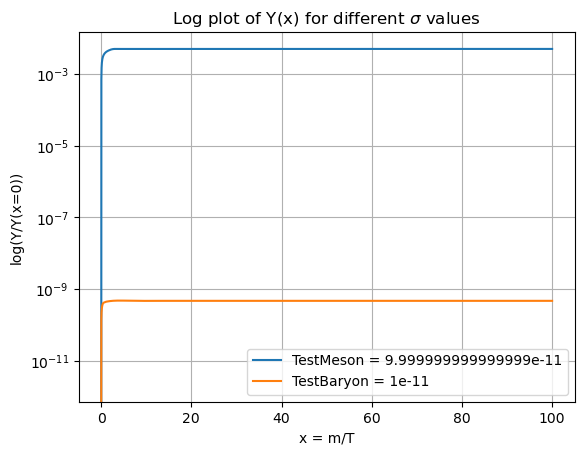

In [47]:
%run FreezeOutFunctions.ipynb
%run CrossSectionFunctions.ipynb

Y0 = [0]  
x_min = 0.01 
x_max = 100 
x_span = (x_min, x_max)
x_eval = np.linspace(x_min, x_max, 500000)

# THE STRING ENCLOSED WITHIN THE "" IS TELLING THE CODE WHAT RATIO TO USE REGARDLESS OF WHAT VARIABLE YOU PASS THROUGH NEXT
sigma_values = {
    "TestMeson": Sigma_Meson,
    "TestBaryon": Sigma_Baryon
}

for particle, sigma_value in sigma_values.items():
    sol = solve_ivp(lambda x, Y: dYdx(x, Y, sigma_value, particle), x_span, Y0, t_eval=x_eval)
    print(particle)
    
    # Number of frozen-out DM particles
    Y_frozen = sol.y[0, -1]
    print(f'Frozen-out Y(x) for {particle} = {Y_frozen}')
    
    plt.plot(sol.t, sol.y[0], label=f'{particle} = {sigma_value}')
    
# Plot configurations
plt.yscale('log')  
#plt.xscale('log')  
plt.xlabel('x = m/T')
plt.ylabel('log(Y/Y(x=0))')
plt.title('Log plot of Y(x) for different $\sigma$ values')
plt.legend()
plt.grid(True)
#plt.savefig('DifferentSigmaSValues.png', facecolor='w')

plt.show()

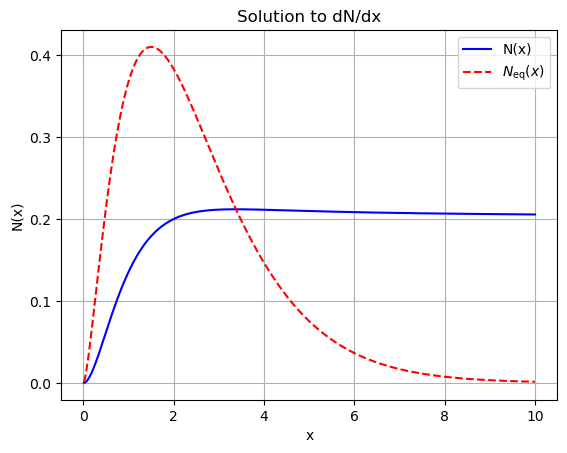

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the equilibrium function N_eq(x)
def N_eq(x):
    return x**(3/2) * np.exp(-x)

# Define the differential equation dN/dx
def dNdx(x, N, Lambda):
    Neq = N_eq(x)
    return (-Lambda / x**2) * (N**2 - Neq**2)

# Solver function
def solve_N(Lambda, x_min=0.01, x_max=10, N0=1e-5, num_points=500):
    x_eval = np.linspace(x_min, x_max, num_points)  # Array of x values
    x_span = (x_min, x_max)  # Range of x values

    # Solve the ODE
    solution = solve_ivp(
        dNdx, x_span, [N0], args=(Lambda,), t_eval=x_eval, method="RK45", rtol=1e-6, atol=1e-9
    )

    return solution.t, solution.y[0]

# Example usage
Lambda_example = 1.0  # Example Lambda value
x_values, N_values = solve_N(Lambda_example)

# Plot results
plt.plot(x_values, N_values, label="N(x)", color="blue")
plt.plot(x_values, N_eq(x_values), label=r"$N_{\text{eq}}(x)$", linestyle="dashed", color="red")
plt.xlabel("x")
plt.ylabel("N(x)")
plt.title("Solution to dN/dx")
plt.legend()
plt.grid()
plt.show()


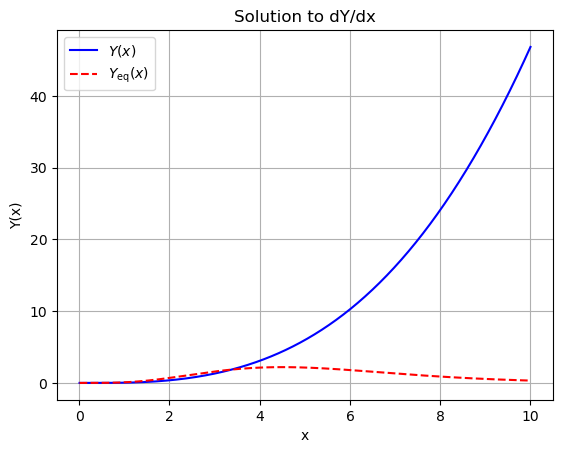

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
c2 = 2 * np.pi**2 / 45  # Given constant in entropy density function

# Placeholder function for g_star(T) [Replace with actual implementation]
def g_star(T):
    return 10  # Example: Replace with an actual function or interpolation from your dataset

# Define entropy density function s(x, m)
def s(x, m):
    T = m / x
    return c2 * g_star(T) * T**3

# Define the equilibrium function N_eq(x)
def N_eq(x):
    return x**(3/2) * np.exp(-x)

# Define the equilibrium function Y_eq(x, m)
def Y_eq(x, m):
    return N_eq(x) / s(x, m)

# Define the differential equation dN/dx
def dNdx(x, N, Lambda, m):
    Neq = N_eq(x)
    return (-Lambda / x**2) * (N**2 - Neq**2)

# Solver function
def solve_Y(Lambda, m, x_min=0.01, x_max=10, N0=1e-5, num_points=500):
    x_eval = np.linspace(x_min, x_max, num_points)  # Array of x values
    x_span = (x_min, x_max)  # Range of x values

    # Solve the ODE for N(x)
    solution = solve_ivp(
        dNdx, x_span, [N0], args=(Lambda, m), t_eval=x_eval, method="RK45", rtol=1e-6, atol=1e-9
    )

    # Compute Y(x) from N(x)
    N_values = solution.y[0]
    Y_values = N_values / s(solution.t, m)
    
    return solution.t, Y_values

# Example usage
Lambda_example = 1.0  # Example Lambda value
mass_example = 1.0    # Example mass value
x_values, Y_values = solve_Y(Lambda_example, mass_example)

# Plot results
plt.plot(x_values, Y_values, label=r"$Y(x)$", color="blue")
plt.plot(x_values, Y_eq(x_values, mass_example), label=r"$Y_{\text{eq}}(x)$", linestyle="dashed", color="red")
plt.xlabel("x")
plt.ylabel("Y(x)")
plt.title("Solution to dY/dx")
plt.legend()
plt.grid()
plt.show()


In [8]:
"""
sigma_values = [Sigma_SC_NeutralPion, Sigma_SC_NeutralKaon]

for sigma_value in sigma_values:
    sigma_name = get_variable_name(sigma_value, globals())
    sol = solve_ivp(lambda x, Y: dYdx(x, Y, sigma_value), x_span, Y0, t_eval=x_eval)
        
    # Number of frozen-out dm particles
    Y_frozen = sol.y[0, -1]
    print(f'Frozen-out Y(x) for {sigma_name} = {sigma_value}: {Y_frozen}')
    
    plt.plot(sol.t, sol.y[0], label=f'{sigma_name} = {sigma_value}')
"""

"\nsigma_values = [Sigma_SC_NeutralPion, Sigma_SC_NeutralKaon]\n\nfor sigma_value in sigma_values:\n    sigma_name = get_variable_name(sigma_value, globals())\n    sol = solve_ivp(lambda x, Y: dYdx(x, Y, sigma_value), x_span, Y0, t_eval=x_eval)\n        \n    # Number of frozen-out dm particles\n    Y_frozen = sol.y[0, -1]\n    print(f'Frozen-out Y(x) for {sigma_name} = {sigma_value}: {Y_frozen}')\n    \n    plt.plot(sol.t, sol.y[0], label=f'{sigma_name} = {sigma_value}')\n"